## Import libraries & mount drive 

In [ ]:
#import libraries
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
import nltk
from nltk.stem import WordNetLemmatizer 
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
import seaborn as sns
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from keras.preprocessing import sequence
from keras import metrics
from keras.models import Sequential
from keras.layers import Dense, Embedding, SimpleRNN, Dropout, LSTM, Bidirectional, Conv1D
import tensorflow as tf 
from tensorflow.keras.optimizers import Adam, SGD
from sklearn.linear_model import LogisticRegression
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization
from google.colab import drive

nltk.download('wordnet')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
#from google.colab import drive
#drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/BT4222/Final/datasets

/content/drive/My Drive/BT4222/Project Dataset/my_dir


## Import original dataset 

In [ ]:
path = 'fake reviews dataset.csv'
df = pd.read_csv(path)
df

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...


## EDA

In [ ]:
df.shape

(40432, 4)

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40432 entries, 0 to 40431
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   category  40432 non-null  object 
 1   rating    40432 non-null  float64
 2   label     40432 non-null  object 
 3   text_     40432 non-null  object 
dtypes: float64(1), object(3)
memory usage: 1.2+ MB


In [ ]:
# check for missing value in any column
df.isnull()

,category,rating,label,text_
0,False,False,False,False
1,False,False,False,False
2,False,False,False,False
3,False,False,False,False
4,False,False,False,False
...,...,...,...,...
40427,False,False,False,False
40428,False,False,False,False
40429,False,False,False,False
40430,False,False,False,False


In [ ]:
#Check for data imbalance
df.groupby('label').size()

label
CG    20216
OR    20216
dtype: int64

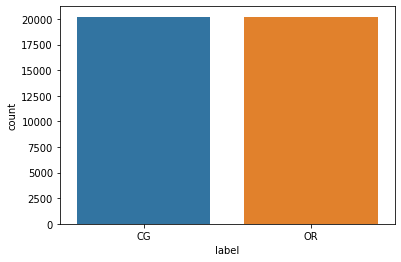

In [ ]:
sns.countplot(x="label", data=df)
plt.show()  

Since there is an equal number of 'CG' and 'OR' rows, the ML algorithm has the same number of examples of both cases to learn from. There is no need to do further data processing and cleaning for balanced categorical data and the dataset can be used for analysis

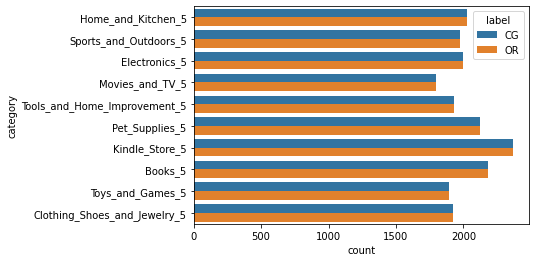

In [ ]:
sns.countplot(y="category", hue="label", data=df)
plt.show()  

In [ ]:
# Group by category, label & rating
df_main = pd.DataFrame(df.groupby(['category', 'label', 'rating'])['rating'].agg(['count']))
df_main = df_main.reset_index()
df_main

,category,label,rating,count
0,Books_5,CG,1.0,90
1,Books_5,CG,2.0,123
2,Books_5,CG,3.0,252
3,Books_5,CG,4.0,471
4,Books_5,CG,5.0,1249
...,...,...,...,...
95,Toys_and_Games_5,OR,1.0,90
96,Toys_and_Games_5,OR,2.0,70
97,Toys_and_Games_5,OR,3.0,175
98,Toys_and_Games_5,OR,4.0,352


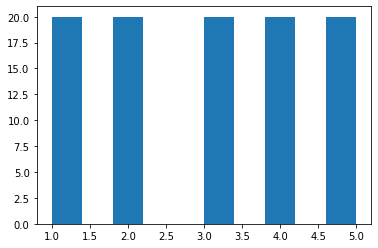

In [ ]:
# Distribution of 'rating' values
x = df_main['rating']
plt.hist(x, bins=10)
plt.show()

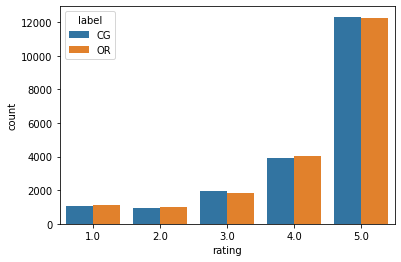

In [ ]:
sns.countplot(x="rating", hue="label", data=df)
plt.show()  

### Analysis of fake reviews

In [ ]:
df_fake = df[df['label'] == 'CG']
df_fake.head()

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...


### Analysing rating column

In [ ]:
print(df_fake['rating'].describe())
df_ratings = df_fake.groupby('rating').size()
df_ratings

count    20216.000000
mean         4.259893
std          1.141065
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


rating
1.0     1063
2.0      962
3.0     1952
4.0     3920
5.0    12319
dtype: int64

In [ ]:
# Group by category 
df_fake.groupby('category')['rating'].agg(['count', 'mean'])

,count,mean
category,,
Books_5,2185,4.220137
Clothing_Shoes_and_Jewelry_5,1924,4.184511
Electronics_5,1994,4.185055
Home_and_Kitchen_5,2028,4.254438
Kindle_Store_5,2365,4.355180
Movies_and_TV_5,1794,4.172241
Pet_Supplies_5,2127,4.216737
Sports_and_Outdoors_5,1973,4.330968
Tools_and_Home_Improvement_5,1929,4.306895


In [ ]:
# Group by category and rating 
df_test = df_fake.groupby(['category', 'rating'])['rating'].agg(['count'])

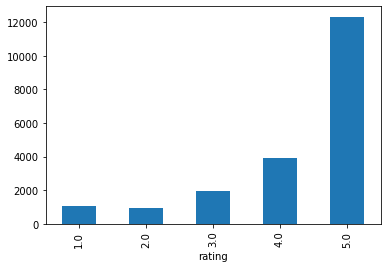

In [ ]:
# find out distribution of rating
df_ratings.plot.bar()

### Analysis of genuine Reviews

In [ ]:
# fake product reviews
df_genuine = df[df['label'] == 'OR']
df_genuine.head()

,category,rating,label,text_
55,Home_and_Kitchen_5,5.0,OR,"These are just perfect, exactly what I was loo..."
56,Home_and_Kitchen_5,5.0,OR,Such a great purchase can't beat it for the price
57,Home_and_Kitchen_5,5.0,OR,What can you say--- cheap and it works as inte...
58,Home_and_Kitchen_5,5.0,OR,"These are so nice, sturdy, like the color choi..."
59,Home_and_Kitchen_5,5.0,OR,It is nice bowl and have had a fast shipping!


In [ ]:
print(df_genuine['rating'].describe())
df_ratings_genuine = df_genuine.groupby('rating').size()
df_ratings_genuine

count    20216.000000
mean         4.253265
std          1.147652
min          1.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: rating, dtype: float64


rating
1.0     1092
2.0     1005
3.0     1834
4.0     4045
5.0    12240
dtype: int64

In [ ]:
# Count number of fake and real reviews, group by category and rating 
df_temp = df_genuine.groupby(['category', 'rating'])['rating'].agg(['count'])
df_final = pd.merge(df_temp, df_test, on = ('category', 'rating'))
df_final.columns = ['fake_count', 'real_count']
df_final

fake_count  real_count
category                     rating                        
Books_5                      1.0             77          90
                             2.0             97         123
                             3.0            229         252
                             4.0            496         471
                             5.0           1286        1249
Clothing_Shoes_and_Jewelry_5 1.0             96         105
                             2.0            132         113
                             3.0            206         197
                             4.0            422         416
                             5.0           1068        1093
Electronics_5                1.0            162         157
                             2.0            108          96
                             3.0            173         168
                             4.0            377         373
                             5.0           1174        1200
Home_and_Kitchen_5           1.0            138         136
                             2.0             99         103
                             3.0            164         173
                             4.0            366         313
                             5.0           1261        1303
Kindle_Store_5               1.0             47          53
                             2.0             76          77
                             3.0            211         236
                             4.0            598         610
                             5.0           1433        1389
Movies_and_TV_5              1.0            120         108
                             2.0            111         105
                             3.0            184         194
                             4.0            390         350
                             5.0            989        1037
Pet_Supplies_5               1.0            154         144
                             2.0            117         115
                             3.0            194         205
                             4.0            341         335
                             5.0           1321        1328
Sports_and_Outdoors_5        1.0            105          89
                             2.0             94          78
                             3.0            152         180
                             4.0            370         370
                             5.0           1252        1256
Tools_and_Home_Improvement_5 1.0            103         113
                             2.0            101          76
                             3.0            146         159
                             4.0            333         339
                             5.0           1246        1242
Toys_and_Games_5             1.0             90          68
                             2.0             70          76
                             3.0            175         188
                             4.0            352         343
                             5.0           1210        1222

### Exploring difference between Fake and Real Reviews

In [ ]:
temp_fake = df_fake[df_fake['rating'] == 1.0]
col_two = temp_fake[['text_']]

In [ ]:
temp = df_genuine[df_genuine['rating'] == 1.0]
col_one = temp[['text_']]

In [ ]:
temp_fake_five = df_fake[df_fake['rating'] == 5.0]
col_three = temp_fake_five[['text_']]

In [ ]:
temp_real_five = df_genuine[df_genuine['rating'] == 5.0]
df_merge = pd.DataFrame(temp_real_five[['text_']])

In [ ]:
col_three

,text_
0,"Love this! Well made, sturdy, and very comfor..."
1,"love it, a great upgrade from the original. I..."
2,This pillow saved my back. I love the look and...
4,Very nice set. Good quality. We have had the s...
6,They are the perfect touch for me and the only...
...,...
40410,There are certain things in this shoe that are...
40412,"OMG, First reason why I chose this style is be..."
40420,I just bought these locally and they are the b...
40426,"Overall, I love this hat!\n\nSize/Color: 9.5/..."


In [ ]:
temp = df[df['rating'] == 1.0]
df_cg_low = temp[temp['label'] == "CG"]
df_cg_low.to_csv(r'low_ratings_fake.csv', index = False)

In [ ]:
temp = df[df['rating'] == 1.0]
df_or_low = temp[temp['label'] == "OR"]
df_or_low.to_csv(r'low_ratings_real.csv', index = False)

### Finding length of sentence (based on no. of words) 

Method: Get length of all reviews --> see distribution --> (1) group by label (2) group by label, rating

In [ ]:
# df['no_of_words'] = pd.NaT
df_length = df.copy()
df_length

,category,rating,label,text_
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor..."
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I..."
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i..."
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...
...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ..."
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...


In [ ]:
df_length['review_length'] = df_length['text_'].apply(lambda x: len(x.split()))
df_length.head()

,category,rating,label,text_,review_length
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",12
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",16
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,14
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",17
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,18


In [ ]:
df_length.describe()

,rating,review_length
count,40432.000000,40432.000000
mean,4.256579,67.465423
std,1.144354,69.581333
min,1.000000,1.000000
25%,4.000000,21.000000
50%,5.000000,39.000000
75%,5.000000,85.000000
max,5.000000,373.000000


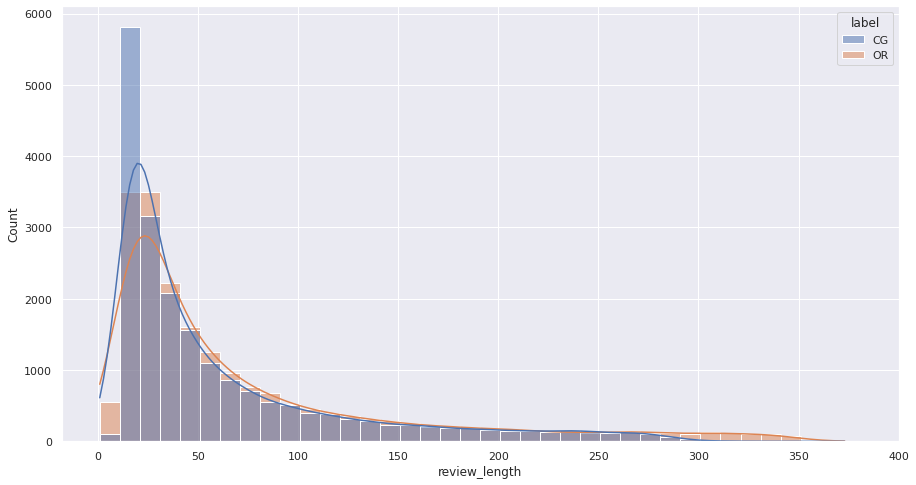

In [ ]:
# Distribution of review_length
sns.set(rc = {'figure.figsize':(15,8)})
fig_three = sns.histplot(x="review_length", hue = "label", binwidth=10, data=df_length, kde=True)
fig_three

### Finding number of reviews that end with punctuation mark 

Method: Get distribution of punctuation of REAL reviews --> see most common --> count ALL reviews that have common punc at the end --> grp by label

In [ ]:
import string
import re

In [ ]:
# added extra column
df['end_with_punc'] = pd.NaT
df_punc = df.copy()
df_punc

,category,rating,label,text_,end_with_punc
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",NaT
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",NaT
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,NaT
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",NaT
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,NaT
...,...,...,...,...,...
40427,Clothing_Shoes_and_Jewelry_5,4.0,OR,I had read some reviews saying that this bra r...,NaT
40428,Clothing_Shoes_and_Jewelry_5,5.0,CG,I wasn't sure exactly what it would be. It is ...,NaT
40429,Clothing_Shoes_and_Jewelry_5,2.0,OR,"You can wear the hood by itself, wear it with ...",NaT
40430,Clothing_Shoes_and_Jewelry_5,1.0,CG,I liked nothing about this dress. The only rea...,NaT


In [ ]:
df_real = df[df['label'] == 'OR']

In [ ]:
# count ALL reviews that have common punc at the end
for i in range(len(df_punc)):
    sentence = df_punc.iloc[i, 3]
    if re.search(patterns, sentence):
        result = 1
        df_punc.iloc[i, 4] = result
    else:
        result = 0
        df_punc.iloc[i, 4] = result

In [ ]:
df_punc.head()

,category,rating,label,text_,end_with_punc
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",0
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",0
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,1
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",0
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,0


In [ ]:
df_punc_count = df_punc.groupby(['label', 'end_with_punc'])['end_with_punc'].agg(['count'])
df_punc_count = df_punc_count.reset_index()

In [ ]:
df_punc_count

,label,end_with_punc,count
0,CG,0,13851
1,CG,1,6365
2,OR,0,2287
3,OR,1,17929


Text(0, 0.5, 'Label')

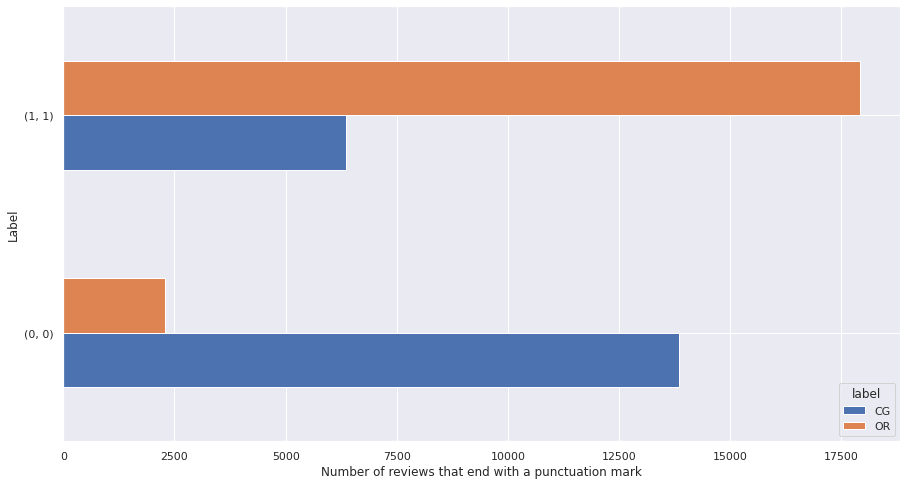

In [ ]:
ax = df_punc.groupby(['label', 'end_with_punc'])['end_with_punc'].value_counts().unstack(0).plot.barh()
ax.set_xlabel('Number of reviews that end with a punctuation mark')
ax.set_ylabel('Label')

## Masterdata derivation

### Add review_length column

In [ ]:
# adding review_length column
df['review_length'] = df['text_'].apply(lambda x: len(x.split()))
df.head()

,category,rating,label,text_,review_length
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",12
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",16
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,14
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",17
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,18


### Add end_with_punc column

In [ ]:
# add column to indicate if review ends with punctuation mark
import string
import re

df['end_with_punc'] = pd.NaT

In [ ]:
df.head()

,category,rating,label,text_,review_length,end_with_punc
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",12,NaT
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",16,NaT
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,14,NaT
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",17,NaT
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,18,NaT


In [ ]:
# define function
patterns = '\w+\S*[?.!]$'

for i in range(len(df)):
    sentence = df.iloc[i, 3]
    if re.search(patterns, sentence):
        result = 1
        df.iloc[i, 5] = result
    else:
        result = 0
        df.iloc[i, 5] = result

In [ ]:
df.head()

### Data cleaning

#### Data cleaning of text_ column

1) Retain original `text` column
- Remove leading and trailing characters
- Remove text from other languages

2) Create `clean_text` column
- Remove punctuations from `text`
- Convert all values to lowercase from `text`
- Remove stopwords
- Spelling Correction from `text`

3) Create `cleaned_text` column
- Perform lemmatisation on words from `clean_text`

4) Perform One Hot Encoding for `category` column


In [ ]:
# Remove leading and trailing characters
df['text_'] = df['text_'].apply(lambda x: x.strip())

In [ ]:
# Remove leading and trailing characters
df['clean_text'] = df['text_'].apply(lambda x: x.strip())

# Convert all column values to lowercase
df['clean_text'] = df['text_'].apply(lambda x: x.lower())

# Remove Punctuation
def remove_punc(x):
    text = x
    new_text = text.translate(str.maketrans('', '', string.punctuation))
    return new_text

df['clean_text'] = df['clean_text'].apply(lambda x: remove_punc(x))

In [ ]:
# target = 1 for FAKE reviews
df["target"] = np.where(df["label"]=="CG", 1, 0)

In [ ]:
df.head()

####Removing stopwords

In [ ]:
stop = stopwords.words('english')
tokenizer = RegexpTokenizer(r'\w+')

def remove_stopwords(text):
    text = tokenizer.tokenize(text)
    #Remove stopwords
    text = [word for word in text if word not in stop and word.isalpha()] 
    text = ' '.join(text) 
    return text

df['clean_text'] = df['clean_text'].apply(lambda x: remove_stopwords(x))

#### Lemmatization 

In [ ]:
#Cleaning data
lemmatizer = WordNetLemmatizer()

def lemmatise_text(text):
    text = tokenizer.tokenize(text)

    #Takes iterable aka list of strings and join them together to become a string
    text = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(text) 
    return text

In [ ]:
df['cleaned_text'] = df['clean_text'].apply(lambda text: lemmatise_text(text))
df

#### OHE for categorical variable

In [ ]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(categories='auto', sparse=False, handle_unknown='ignore')

df_ohe = pd.DataFrame(enc.fit_transform(df[['category']]))
df_ohe.columns = enc.get_feature_names_out(['category'])
#df.drop(['category'] ,axis=1, inplace=True) # only run once to remove original category column
OHE_df= pd.concat([df, df_ohe], axis=1)

In [ ]:
df.shape

In [ ]:
OHE_df.shape

In [ ]:
df = OHE_df.copy()

In [ ]:
df.head()

####Removing text from other languages

In [ ]:
#pip install langdetect

In [ ]:
import langdetect

txt = df.loc[:,'clean_text']
df['lang'] = txt.apply(lambda x: langdetect.detect(x) if x.strip() != "" else "")
df.head()

In [ ]:
df.groupby(['lang'])['lang'].agg(['count'])

In [ ]:
df = df.loc[df['lang'] == 'en']
df.head()

In [ ]:
df.shape

####Spelling Correction

In [ ]:
#!pip install pyspellchecker
from pyspellchecker import SpellChecker

In [ ]:
spell = SpellChecker()
def correct_spellings(text):
    corrected_text = []
    misspelled_words = spell.unknown(text.split())
    for word in text.split():
        if word in misspelled_words:
            corrected_text.append(spell.correction(word))
        else:
            corrected_text.append(word)
    return " ".join(corrected_text)
        
df["clean_text"] = df["clean_text"].apply(lambda text: correct_spellings(text))

#### Export final df as csv to drive

In [ ]:
df.shape

(39025, 20)

In [ ]:
df.head()

,category,rating,label,text_,review_length,end_with_punc,clean_text,target,cleaned_text,category_Books_5,category_Clothing_Shoes_and_Jewelry_5,category_Electronics_5,category_Home_and_Kitchen_5,category_Kindle_Store_5,category_Movies_and_TV_5,category_Pet_Supplies_5,category_Sports_and_Outdoors_5,category_Tools_and_Home_Improvement_5,category_Toys_and_Games_5,lang
0,Home_and_Kitchen_5,5.0,CG,"Love this! Well made, sturdy, and very comfor...",12,0,love well made sturdy comfortable love itvery ...,1,love well made sturdy comfortable love itvery ...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,en
1,Home_and_Kitchen_5,5.0,CG,"love it, a great upgrade from the original. I...",16,0,love great upgrade original ive mine couple years,1,love great upgrade original ive mine couple year,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,en
2,Home_and_Kitchen_5,5.0,CG,This pillow saved my back. I love the look and...,14,1,pillow saved back love look feel pillow,1,pillow saved back love look feel pillow,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,en
3,Home_and_Kitchen_5,1.0,CG,"Missing information on how to use it, but it i...",17,0,missing information use great product price,1,missing information use great product price,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,en
4,Home_and_Kitchen_5,5.0,CG,Very nice set. Good quality. We have had the s...,18,0,nice set good quality set two months,1,nice set good quality set two month,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,en


In [ ]:
# generate csv
# df.to_csv('masterdata.csv', index=False)
df.to_csv('/content/drive/My Drive/BT4222/Final Submission/datasets/masterdata.csv', index=False)

## Word cloud

In [ ]:
reviews_check = df.copy()

In [ ]:
#Word Cloud
stopwords = set(STOPWORDS)
def show_wordcloud(data, title = None):
    wordcloud = WordCloud(
        background_color='white',
        stopwords=stopwords,
        max_words=200,
        max_font_size=40, 
        scale=3,
        random_state=1 # chosen at random by flipping a coin; it was heads
    ).generate(str(data))

    fig = plt.figure(1, figsize=(12, 12))
    plt.axis('off')
    if title: 
        fig.suptitle(title, fontsize=20)
        fig.subplots_adjust(top=2.3)

    plt.imshow(wordcloud)
    plt.show()

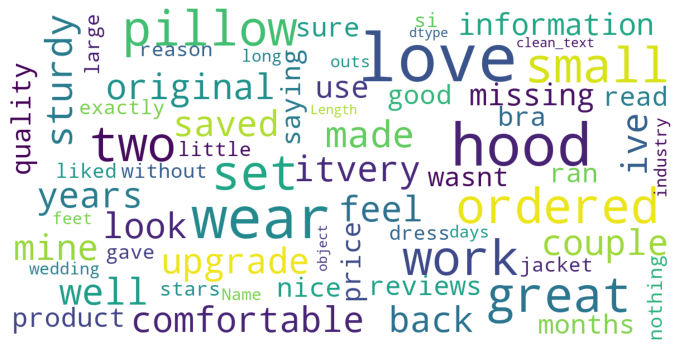

In [ ]:
# word cloud for all reviews
show_wordcloud(reviews_check['clean_text']) 

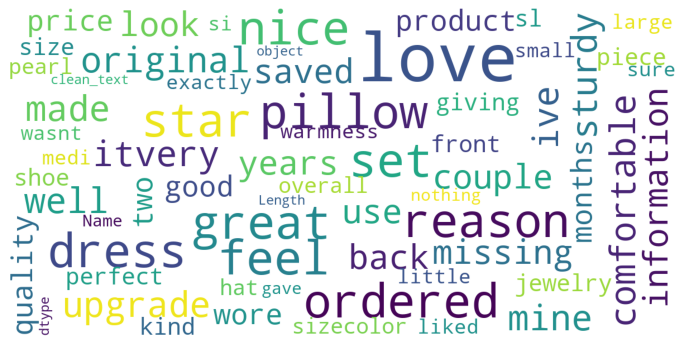

In [ ]:
# word cloud for CG reviews (target = 1)
show_wordcloud(reviews_check[reviews_check['target']== 1]['clean_text']) 

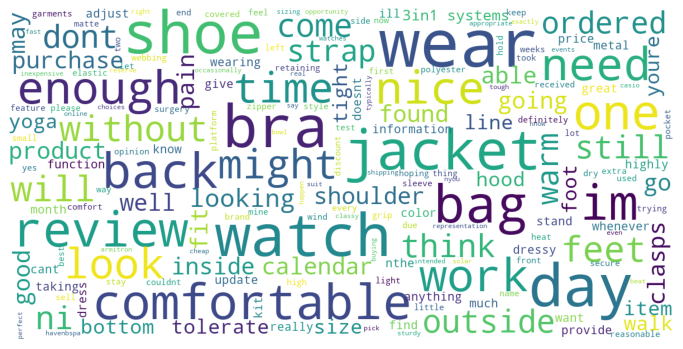

In [ ]:
# word cloud for OR reviews (target = 0)
show_wordcloud(reviews_check[reviews_check['target']== 0]['clean_text']) 

# Hypothesis 1: Lemmatisation

Test performance of lemmatised `cleaned_text` vs unlemmatised data `clean_text` using Logistic Regression and Naive Bayes models

###Create new train and test sets with lemmatised and unlemmatised document term matrix

In [ ]:
# Using the new masterdata here
df_1 = pd.read_csv('masterdata.csv')

In [ ]:
df_1 = df_1.drop(columns=['category', 'label', 'text_', 'lang'])

In [ ]:
from sklearn.model_selection import train_test_split

X = df_1.drop(columns=['target'])
X = X.loc[:, :]
y = pd.DataFrame(df_1.loc[:,'target'])

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle = True, test_size = 0.2) #20% test

In [ ]:
X_train_lemmatised = X_train.drop(columns = 'clean_text')
X_train_unlemmatised = X_train.drop(columns = 'cleaned_text')
X_test_lemmatised = X_test.drop(columns = 'clean_text')
X_test_unlemmatised = X_test.drop(columns = 'cleaned_text')

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

vect_lemmatised = CountVectorizer()
vect_unlemmatised = CountVectorizer()

#fit only on train data
X_train_dtm_lemmatised = vect_lemmatised.fit_transform(X_train_lemmatised.cleaned_text)
X_train_dtm_unlemmatised = vect_unlemmatised.fit_transform(X_train_unlemmatised.clean_text)

X_test_dtm_lemmatised = vect_lemmatised.transform(X_test_lemmatised.cleaned_text)
X_test_dtm_unlemmatised = vect_unlemmatised.transform(X_test_unlemmatised.clean_text)

In [ ]:
X_train_dtm_lemmatised.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# drop the original textual data
X_train_lemmatised = X_train_lemmatised.drop(columns='cleaned_text') 
X_train_unlemmatised = X_train_unlemmatised.drop(columns = 'clean_text')

X_test_lemmatised  = X_test_lemmatised.drop(columns='cleaned_text')
X_test_unlemmatised  = X_test_unlemmatised.drop(columns='clean_text')

In [ ]:
#stack existing values with dtm values
X_train_lemmatised = np.hstack((X_train_lemmatised.values, X_train_dtm_lemmatised.toarray()))
X_train_unlemmatised = np.hstack((X_train_unlemmatised.values, X_train_dtm_unlemmatised.toarray()))

X_test_lemmatised = np.hstack((X_test_lemmatised.values, X_test_dtm_lemmatised.toarray()))
X_test_unlemmatised = np.hstack((X_test_unlemmatised.values, X_test_dtm_unlemmatised.toarray()))

#stack existing columns with dtm columns
new_cols_train = np.hstack((X_train_lemmatised.columns,vect_lemmatised.get_feature_names_out()))
new_cols_test = np.hstack((X_test_lemmatised.columns, vect_lemmatised.get_feature_names_out()))

#convert to dataframe
X_train_lemmatised = pd.DataFrame(X_train_lemmatised, columns = new_cols_train)
X_train_unlemmatised = pd.DataFrame(X_train_unlemmatised, columns = new_cols_train)
X_test_lemmatised = pd.DataFrame(X_test_lemmatised, columns = new_cols_test)
X_test_unlemmatised = pd.DataFrame(X_test_unlemmatised, columns = new_cols_test)

### Part I: Logistic Regression model

In [ ]:
#fit logreg model with lemmatised data
logreg = LogisticRegression(max_iter=800)
res_lemma = logreg.fit(X_train_lemmatised, y_train)
y_pred_train_lemmatised = res_lemma.predict(X_train_lemmatised) #training accuracy
y_pred_test_lemmatised = res_lemma.predict(X_test_lemmatised)   #test accuracy

In [ ]:
#evaluating model performance
train_accuracy = metrics.accuracy_score(y_train_lemma, y_pred_train)
test_accuracy = metrics.accuracy_score(y_test_lemma, y_pred_test)
print("Train Accuracy: ", round(train_accuracy,2)*100,'%')
print("Details for train: ", metrics.classification_report(y_train_lemma, y_pred_train))
print("Test Accuracy: ", round(test_accuracy,2)*100,'%')
print("Details for test: ", metrics.classification_report(y_test_lemma, y_pred_test))

Train Accuracy:  87.0 %
Details for train:                precision    recall  f1-score   support

           0       0.87      0.88      0.88     15166
           1       0.88      0.87      0.87     15111

    accuracy                           0.87     30277
   macro avg       0.87      0.87      0.87     30277
weighted avg       0.87      0.87      0.87     30277

Test Accuracy:  87.0 %
Details for test:                precision    recall  f1-score   support

           0       0.86      0.88      0.87      5029
           1       0.88      0.86      0.87      5064

    accuracy                           0.87     10093
   macro avg       0.87      0.87      0.87     10093
weighted avg       0.87      0.87      0.87     10093



In [ ]:
#fit logreg model with unlemmatised data
logreg = LogisticRegression(max_iter=800)
res = logreg.fit(X_train_unlemmatised, y_train)
y_pred_train_unlemmatised = res.predict(X_train_unlemmatised) #training accuracy
y_pred_test_unlemmatised = res.predict(X_test_unlemmatised)   #test accuracy

In [ ]:
#evaluating model performance
train_accuracy = metrics.accuracy_score(y_train, y_pred_train_unlemmatised)
test_accuracy = metrics.accuracy_score(y_test, y_pred_test_unlemmatised)
print("Train Accuracy: ", round(train_accuracy,2)*100,'%')
print("Details for train: ", metrics.classification_report(y_train, y_pred_train_unlemmatised))
print("Test Accuracy: ", round(test_accuracy,2)*100,'%')
print("Details for test: ", metrics.classification_report(y_test,y_pred_test_unlemmatised))

Train Accuracy:  89.0 %
Details for train:                precision    recall  f1-score   support

           0       0.89      0.90      0.90     15166
           1       0.90      0.89      0.89     15111

    accuracy                           0.89     30277
   macro avg       0.89      0.89      0.89     30277
weighted avg       0.89      0.89      0.89     30277

Test Accuracy:  89.0 %
Details for test:                precision    recall  f1-score   support

           0       0.89      0.90      0.89      5029
           1       0.90      0.89      0.89      5064

    accuracy                           0.89     10093
   macro avg       0.89      0.89      0.89     10093
weighted avg       0.89      0.89      0.89     10093



Unlemmatised data performs better for Logistic Regression models.

### Part II: Naive Bayes Model

In [ ]:
# fit nb model with lemmatised data
nb = MultinomialNB()
nb_lemma = nb.fit(X_train_lemmatised, y_train.values.ravel())
y_pred_train_lemmatised_nb = nb_lemma.predict(X_train_lemmatised) # training accuracy
y_pred_test_lemmatised_nb = nb_lemma.predict(X_test_lemmatised)   # test accuracy


#evaluating model performance
train_accuracy = metrics.accuracy_score(y_train, y_pred_train_lemmatised_nb)
test_accuracy = metrics.accuracy_score(y_test, y_pred_test_lemmatised_nb)
print("Train Accuracy: ", round(train_accuracy,4)*100,'%')
print("Details for train: ", metrics.classification_report(y_train, y_pred_train_lemmatised_nb))
print("Test Accuracy: ", round(test_accuracy,4)*100,'%')
print("Details for test: ", metrics.classification_report(y_test, y_pred_test_lemmatised_nb))
print('')

# calculate AUC
y_pred_prob_lemmatised_nb = nb_lemma.predict_proba(X_test_lemmatised)[:, 1]
y_pred_prob_lemmatised_nb_auc = metrics.roc_auc_score(y_test, y_pred_prob_lemmatised_nb)

print('NB_lemmatised_pred_auc', ':', y_pred_prob_lemmatised_nb_auc)

Train Accuracy:  88.03 %
Details for train:                precision    recall  f1-score   support

           0       0.93      0.82      0.87     16139
           1       0.84      0.94      0.89     16150

    accuracy                           0.88     32289
   macro avg       0.89      0.88      0.88     32289
weighted avg       0.89      0.88      0.88     32289

Test Accuracy:  85.72999999999999 %
Details for test:                precision    recall  f1-score   support

           0       0.90      0.80      0.85      4054
           1       0.82      0.91      0.86      4019

    accuracy                           0.86      8073
   macro avg       0.86      0.86      0.86      8073
weighted avg       0.86      0.86      0.86      8073


NB_lemmatised_pred_auc : 0.9447013096278125


In [ ]:
# fit nb model with unlemmatised data
nb = MultinomialNB()
nb_unlemma = nb.fit(X_train_unlemmatised, y_train.values.ravel())
y_pred_train_unlemmatised_nb = nb_unlemma.predict(X_train_unlemmatised) # training accuracy
y_pred_test_unlemmatised_nb = nb_unlemma.predict(X_test_unlemmatised)   # test accuracy


#evaluating model performance
train_accuracy = metrics.accuracy_score(y_train, y_pred_train_unlemmatised_nb)
test_accuracy = metrics.accuracy_score(y_test, y_pred_test_unlemmatised_nb)
print("Train Accuracy: ", round(train_accuracy,4)*100,'%')
print("Details for train: ", metrics.classification_report(y_train, y_pred_train_unlemmatised_nb))
print("Test Accuracy: ", round(test_accuracy,4)*100,'%')
print("Details for test: ", metrics.classification_report(y_test, y_pred_test_unlemmatised_nb))
print('')

# calculate AUC
y_pred_prob_unlemmatised_nb = nb_unlemma.predict_proba(X_test_unlemmatised)[:, 1]
y_pred_prob_unlemmatised_nb_auc = metrics.roc_auc_score(y_test, y_pred_prob_unlemmatised_nb)

print('NB_unlemmatised_pred_auc', ':', y_pred_prob_unlemmatised_nb_auc)

Train Accuracy:  88.6 %
Details for train:                precision    recall  f1-score   support

           0       0.93      0.83      0.88     16139
           1       0.85      0.94      0.89     16150

    accuracy                           0.89     32289
   macro avg       0.89      0.89      0.89     32289
weighted avg       0.89      0.89      0.89     32289

Test Accuracy:  86.08 %
Details for test:                precision    recall  f1-score   support

           0       0.91      0.80      0.85      4054
           1       0.82      0.92      0.87      4019

    accuracy                           0.86      8073
   macro avg       0.87      0.86      0.86      8073
weighted avg       0.87      0.86      0.86      8073


NB_unlemmatised_pred_auc : 0.9479299916418227


### **Conclusion**

Since unlemmatised data resulted in greater accuracies in both Logistic Regression and Naive Bayes models, we will proceed to use unlemmatised data to train our subsequent models.